# **Побудова моделі бінарної класифікації**
Зчитуємо отриманий датасет з деліметром таб ("\t")

In [2]:
import pandas as pd

df = pd.read_csv('train_df.csv', sep='\t')

display(df)

,Unnamed: 0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,num_8,...,num_413,cat_132,cat_133,num_414,num_415,num_416,cat_134,cat_135,id,gb
0,0,1377.3,3712.9,NaN,1303.0,2409.0,1281.7,43.0,1,195.0,...,11327.5,1,1,28162496.65,0.0,0.07,1,1,1,0
1,1,20.0,13.4,NaN,565.0,NaN,357.2,19.0,1,170.0,...,168.6,1,1,989383.82,0.0,0.56,2,1,2,0
2,4,150.6,1.8,NaN,2294.0,15.0,107.6,76.0,1,196.0,...,209.1,1,1,87444.51,0.0,0.01,3,1,3,0
3,5,11.4,178.0,NaN,1236.0,NaN,350.6,41.0,1,117.0,...,56.9,1,1,297608.00,0.0,0.08,4,1,4,0
4,6,5372.0,3386.0,NaN,1340.0,NaN,14.0,45.0,1,9.0,...,31.0,1,1,6614247.89,0.0,0.20,1,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26819,61104,NaN,NaN,NaN,108.0,NaN,85.6,4.0,1,123.0,...,181.4,1,1,840801.82,0.0,0.09,7,1,5242,0
26820,61105,4.2,97.2,NaN,2149.0,130.5,409.3,72.0,1,157.0,...,596.7,1,1,557554.94,0.0,0.26,5,1,4320,0
26821,61108,4368.0,5004.0,NaN,2215.0,478.0,3176.0,74.0,1,381.0,...,0.0,1,2,17821295.19,0.0,0.37,3,1,2516,0
26822,61110,NaN,NaN,NaN,135.0,NaN,25.7,4.0,1,151.0,...,1494.9,1,1,7228675.60,0.0,0.00,4,1,4610,0


Для початку перевірено наявність **Nan** в колонках з категоріальними значеннями. В результаті з'ясували, що жодна колонка не містить пропусків.

In [3]:
cat_columns = [col for col in df.columns if col.startswith('cat_')]


null_counts_categorical_desc = df[cat_columns].isnull().sum().sort_values(ascending=False)

print(null_counts_categorical_desc)


cat_1      0
cat_86     0
cat_100    0
cat_99     0
cat_98     0
          ..
cat_40     0
cat_39     0
cat_38     0
cat_37     0
cat_135    0
Length: 135, dtype: int64


Тепер перевіримо наявність пропусків в числових змінних. Отримано доволі багато **Nan** в деяких колонках.

In [4]:
num_columns = [col for col in df.columns if col.startswith('num_')]

# Підрахунок відсутніх значень для вибраних числових стовпців і сортування у порядку спадання
null_counts_numerical_desc = df[num_columns].isnull().sum().sort_values(ascending=False)

print(null_counts_numerical_desc)
print(df.shape)

num_266    26824
num_242    26824
num_375    26824
num_66     26824
num_342    26824
           ...  
num_179        0
num_331        0
num_330        0
num_180        0
num_209        0
Length: 416, dtype: int64
(26824, 554)


Видалимо колонки, які не містять жодної інформації. Також видалимо колонку *id*, оскільки дані належать до множини, на якій не можна задати порядок.

In [5]:
df = df.dropna(axis=1, how='all')
df = df.drop(columns=['id'])
print(df.shape)


(26824, 541)


Далі обробляємо колонки, які містять певну інформацію. Тестування навченої моделі показали, що найкраще залишити колонки де кількість **Nan** не перевищує 70% від всієї кількості значень. Інші видаляємо, оскільки невелика інформативність колонки погіршує якість моделі.

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
columns_to_drop = percent_missing[percent_missing > 70].index
df = df.drop(columns=columns_to_drop)
print(df.shape)

(26824, 400)


Для колонок, які містять пропуски, замінимо **Nan** середнім значенням по колонці. (Деякі алгоритми машинного навчання, мають вбудовані алгоритми обробки пропусків. XgBoost, який буде взято за основу в подальших кроках, містить такі механізми теж. Але алгоритм *SMOTE*, який потрібно буде застосувати, не містить алгоритмів обробки **Nan**. Тому в даному випадку було обрано саме такий спосіб обробки пропусків).

In [7]:
for column in df.filter(regex='^num_').columns:
    df[column].fillna(df[column].mean(), inplace=True)


C:\Users\Sasha\AppData\Local\Temp\ipykernel_3600\3398945759.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


Перевіримо співвідношення значень цільової функції. Результат: дані не є збаланосованими.

[0 1] [26231   593]


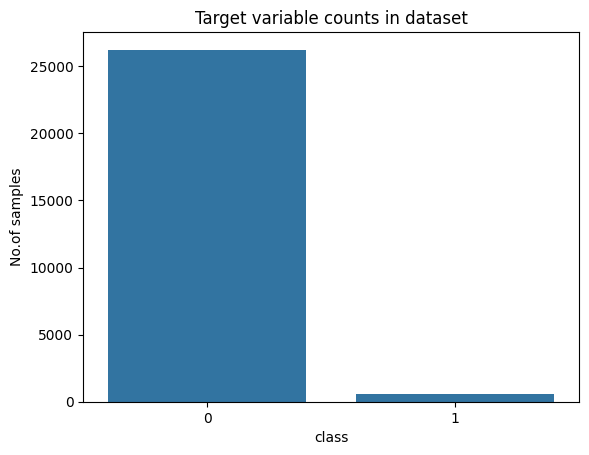

In [8]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
(unique, counts) = np.unique(df['gb'], return_counts=True)
print(unique, counts)
sns.barplot(x=unique,y=counts)
plt.xlabel("class")
plt.ylabel("No.of samples")
plt.xticks()
plt.title('Target variable counts in dataset')
plt.show()

Далі потрібно обробити числові та категоріальні змінні. Для обробки категоріальних є два способи:
- OneHotEncoder
- LabelEncoder

Оскільки, ми не знаємо природу більшості категоріальних змінних, застосування *LabelEncoder* не є доречним, бо змінні мають бути такими, які можна впорядкувати за певною ознакою. Тому використаємо *OneHotEncoder*, який розіб'є кожну колонку на бінарні значення.

Тепер обробимо числові. Можна залишити їх як є, але для покращення навчання моделі, можна скористатися методом *StandardScaler*.
$$
z = \frac{(x - \mu)}{\sigma}
$$
 Цей спосіб масштабує числові змінні, віднімаючи середнє і ділячи на стандартне відхилення, що допомагає покращити процес навчання багатьох алгоритмів машинного навчання.

 На цьому етапі датасет було поділено на навчальну та тестову вибірку у співввідношенні 80 на 20. Оскільки дані не є такими, що можна впорядкувати, поділ на трейн і тест є довільним. 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

cat_features = [col for col in df.columns if col.startswith('cat_')]
num_features = [col for col in df.columns if col.startswith('num_')]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        #('num', FunctionTransformer(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)])


X = df.drop('gb', axis=1)
y = df['gb']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

На даному етапі відбувається навчання моделі за допомогою алгоритму **XgBoost**. Даний алгоритм непогано працює з незбалансованими даними та розрідженими матрицями. Для оцінки якості моделі було застосовано метрику **AUC-ROC** . В результаті отримали досить високі показники, як для трейну так і для тесту. Різниця між показниками тесту/трейну < 2%. Але для незбалансованих даних цього недостатньо: мажоритарного значення цільової функції набагато більше ніж мінітарного і модель може дуже добре передбачати мажоритарні значення, а мінітарні значно гірше, бо їх менше. 

Отже, потрібно перевірити такі показники, як **precision**, **recall**, **f1-score**. Для покращення цих показників було використано 2 методи обробки незбалансованої вибірки:
- Resampling (Oversampling and Undersampling) - this technique is used to upsample or downsample the minority or majority class.
- SMOTE (Synthetic Minority Oversampling Technique) - SMOTE looks into minority class instances and use k nearest neighbor to select a random nearest neighbor, and a synthetic instance is created randomly in feature space.

Також для покращення якості моделі були застосовані гіперпараметри *cale_pos_weight*, *max_depth*, *subsample*, *n_estimators*. Відповідні коефіцієнти були підібрані в процесі тюнинга моделі.

AUC для навчального набору: 1.0
AUC для тестового набору: 0.9954218820581988


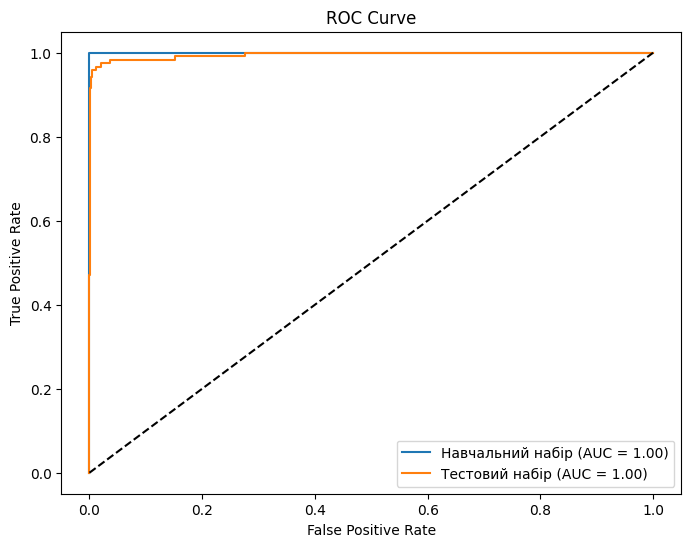

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb


# model = ImbPipeline(steps=[('preprocessor', preprocessor),
#                            ('sampling', SMOTE(random_state=42)),
#                            ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
xgb_params = {
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'scale_pos_weight': 3,  # Співвідношення класів, може допомогти збалансувати навчання
    'max_depth': 6,  # Глибина дерев, впливає на складність моделі
    #'min_child_weight': 1,  # Мінімальна сума ваги всіх спостережень, необхідна в дитині
    'subsample': 0.87,  # Частка вибірки для навчання кожного дерева
    #'gamma': 0.07,
    #'colsample_bytree': 0.9,  # Частка фіч, які використовуються для кожного дерева
    #'learning_rate': 0.26,  # Швидкість навчання
    'n_estimators': 200,  # Кількість дерев
}

model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampling_over', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('sampling_under', RandomUnderSampler(sampling_strategy=0.8, random_state=42)),
    #('sampling', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(**xgb_params))
])


model.fit(X_train, y_train)

y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f'AUC для навчального набору: {auc_train}')
print(f'AUC для тестового набору: {auc_test}')

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Навчальний набір (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Тестовий набір (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Виведення класифікаційного звіту та матриці невідповідностей (з неї вираховуються основні показники **precision**, **recall**, **f1-score**) для тестових даних. Всі показники є досить високими, що свідчить про високу якість роботи моделі.

Класифікаційний звіт:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5246
           1       0.94      0.90      0.92       119

    accuracy                           1.00      5365
   macro avg       0.97      0.95      0.96      5365
weighted avg       1.00      1.00      1.00      5365

Матриця невідповідностей:
[[5239    7]
 [  12  107]]


C:\Users\Sasha\AppData\Local\Temp\ipykernel_3600\256132440.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(set(y_test)))
C:\Users\Sasha\AppData\Local\Temp\ipykernel_3600\256132440.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(set(y_test)))


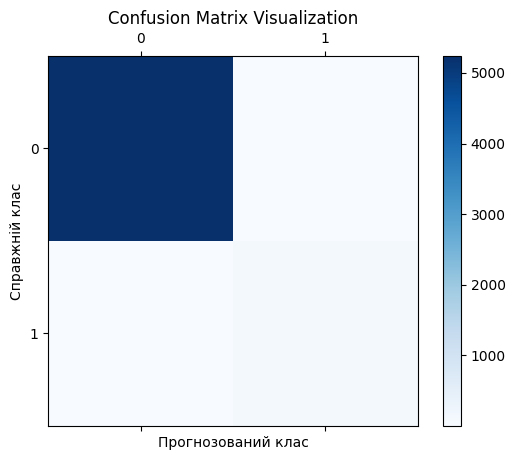

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred_classes = model.predict(X_test)
print("Класифікаційний звіт:")
print(classification_report(y_test, y_test_pred_classes))


print("Матриця невідповідностей:")
cm = confusion_matrix(y_test, y_test_pred_classes)
print(cm)


fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xlabel('Прогнозований клас')
ax.set_ylabel('Справжній клас')
ax.set_xticklabels([''] + list(set(y_test)))
ax.set_yticklabels([''] + list(set(y_test)))
plt.title('Confusion Matrix Visualization')
plt.show()

Варто показати чому було обрано саме **XgBoost**. Побудуємо ще 3 моделі за допомогою таких методів:
- Logistic Regression
- Decision Tree
- Naive Bayes

Також побудуємо ще одну модель за допомогою **XgBoost** без гіперпараметрів. Тобто порівняємо базові версії алгоритмів (для кожного метода було застосовано обробку незбалансованих даних). Ці алгоритми було обрано через їхню здатність працювати з розрідженими матрицями, які утворилися при обробці категоріальних змінних за допомогою OneHotEncoder. 

Було побудовано графіки та виведено основні метрики для кожної моделі.

Logistic Regression: AUC для тренувального набору = 1.00, AUC для тестового набору = 0.99


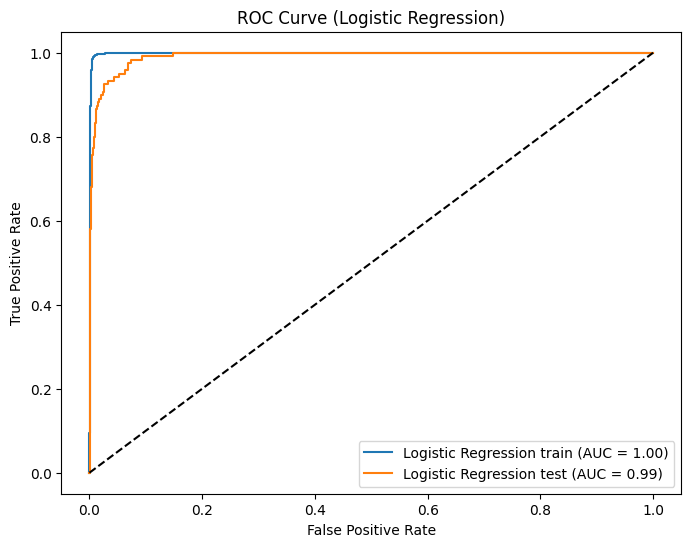

Logistic Regression: Класифікаційний звіт:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5246
           1       0.60      0.87      0.71       119

    accuracy                           0.98      5365
   macro avg       0.80      0.93      0.85      5365
weighted avg       0.99      0.98      0.99      5365

Logistic Regression: Матриця невідповідностей:
[[5178   68]
 [  16  103]]


Decision Tree: AUC для тренувального набору = 1.00, AUC для тестового набору = 0.83


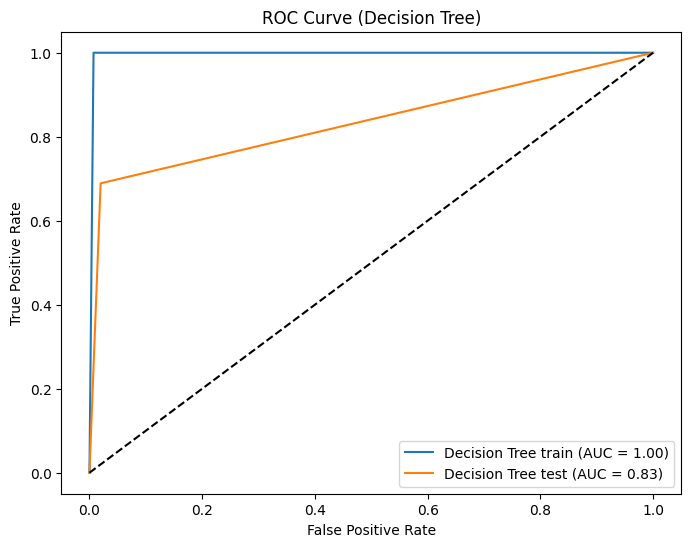

Decision Tree: Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5246
           1       0.44      0.69      0.54       119

    accuracy                           0.97      5365
   macro avg       0.72      0.83      0.76      5365
weighted avg       0.98      0.97      0.98      5365

Decision Tree: Матриця невідповідностей:
[[5142  104]
 [  37   82]]


Naive Bayes: AUC для тренувального набору = 0.92, AUC для тестового набору = 0.90


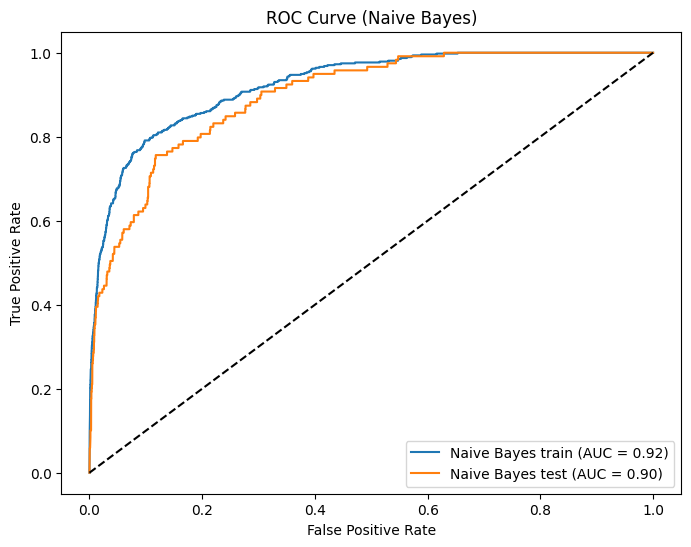

Naive Bayes: Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      5246
           1       0.11      0.76      0.19       119

    accuracy                           0.85      5365
   macro avg       0.55      0.81      0.55      5365
weighted avg       0.97      0.85      0.90      5365

Naive Bayes: Матриця невідповідностей:
[[4492  754]
 [  28   91]]


XGBoost: AUC для тренувального набору = 1.00, AUC для тестового набору = 1.00


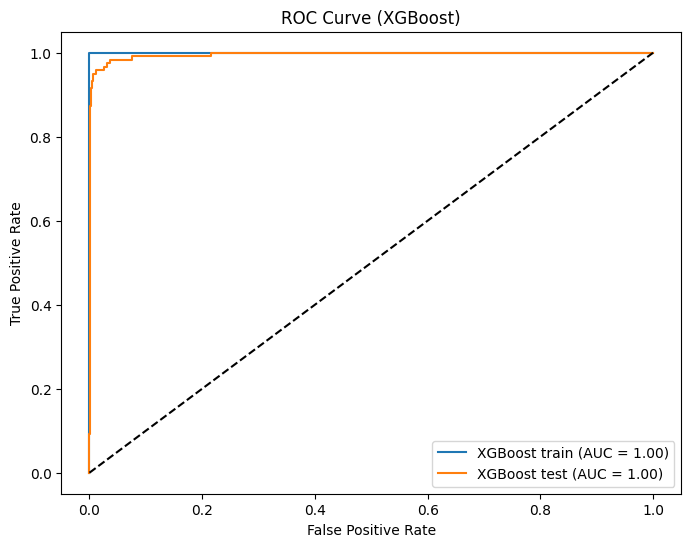

XGBoost: Класифікаційний звіт:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5246
           1       0.93      0.81      0.86       119

    accuracy                           0.99      5365
   macro avg       0.96      0.90      0.93      5365
weighted avg       0.99      0.99      0.99      5365

XGBoost: Матриця невідповідностей:
[[5239    7]
 [  23   96]]




In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    #'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    #'Random Forest': RandomForestClassifier(),
    'Naive Bayes': BernoulliNB(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

models_list = []
precision_list = []
recall_list = []
f1_score_list = []


for name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampling_over', SMOTE(sampling_strategy=0.5, random_state=42)),
        ('sampling_under', RandomUnderSampler(sampling_strategy=0.8, random_state=42)),
        ('classifier', model)
    ])
    
    
    pipeline.fit(X_train, y_train)
    
    
    y_train_pred = pipeline.predict_proba(X_train)[:, 1]
    y_test_pred = pipeline.predict_proba(X_test)[:, 1]
    
    
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)
    print(f'{name}: AUC для тренувального набору = {auc_train:.2f}, AUC для тестового набору = {auc_test:.2f}')
    
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'{name} train (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'{name} test (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend(loc='lower right')
    plt.show()
    
    
    y_test_pred_classes = pipeline.predict(X_test)
    print(f"{name}: Класифікаційний звіт:")
    print(classification_report(y_test, y_test_pred_classes))
    
    report = classification_report(y_test, y_test_pred_classes, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    
    models_list.append(name)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)

    cm = confusion_matrix(y_test, y_test_pred_classes)
    print(f"{name}: Матриця невідповідностей:")
    print(cm)
    print("\n")

З отриманих даних побудуємо порівняльну гістограму, яка складається з показників **precision**, **recall**, **f1-score** кожної моделі.

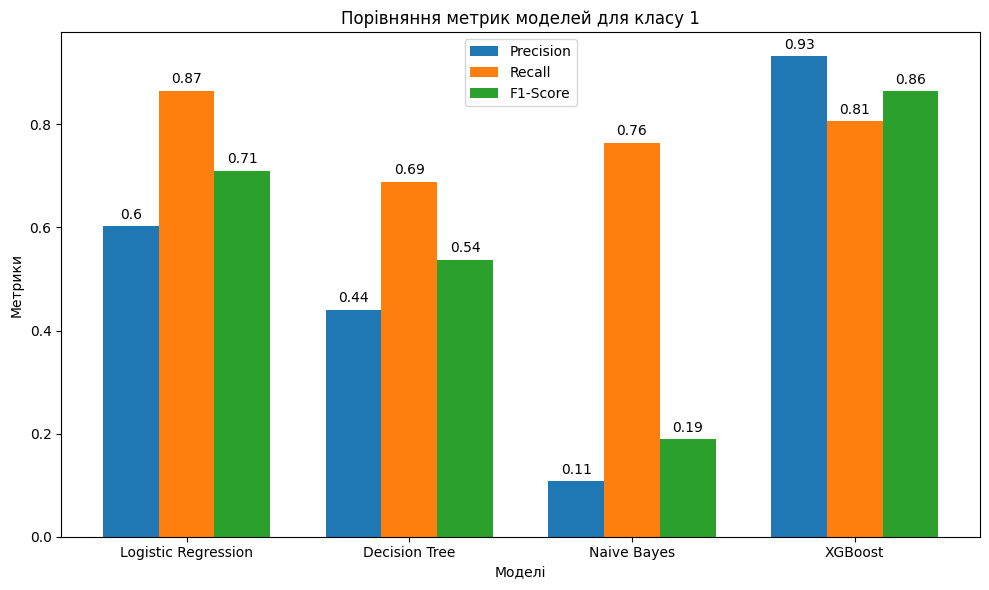

In [13]:
x = np.arange(len(models_list))  
width = 0.25  
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision_list, width, label='Precision')
rects2 = ax.bar(x, recall_list, width, label='Recall')
rects3 = ax.bar(x + width, f1_score_list, width, label='F1-Score')


ax.set_xlabel('Моделі')
ax.set_ylabel('Метрики')
ax.set_title('Порівняння метрик моделей для класу 1')
ax.set_xticks(x)
ax.set_xticklabels(models_list)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

З отриманих графіків та гістограм наочно видно, що **XgBoost** переважає свої аналоги майже по всім показникам. Але для побудови моделі на цих даних також можна було використовувати і **Logistic Regression**, яка теж має високі показники.